# Example notebook for import-export operations with pyMOE

In the following is exemplified how to: 

* Transform a (multi-layer) .gds file into a grayscale image file (allowed extensions as accepted by opencv, e.g. .tiff, .png, .jpg ...)

* Transform a grayscale image file into a dithered image file

* Transform a grayscale image file (.tiff, .png, ...) into a gds file (with  squared pixels) 

* Extra: Merge all pixels (or shapes) in a layer inside a .gds file 

In [1]:
# Notebook display options, change as your preference/system
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w",'bbox_inches':None}

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [2]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

from matplotlib import pyplot as plt 
import numpy as np 

from scipy.constants import micro, nano, milli

import pyMOE as moe 

## Export a created mask using gdsconverter

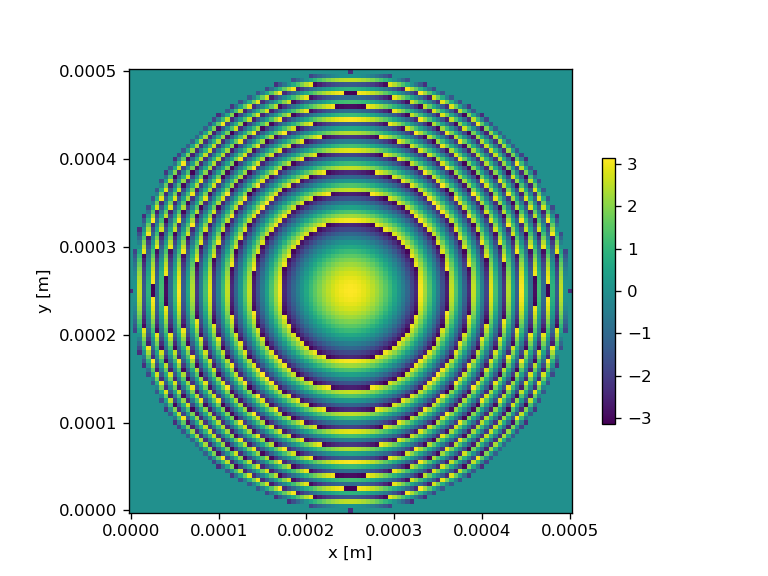

In [27]:
###Here we create a gds/dxf file using the generate and the gdsconverter modules 

####generate a fresnel phase mask and save it into gds 
N_pixels = 101 # nr of pixels 
focal_distance = 5000*micro # focal distance in um 

refractive_index_633 = 1.630115
wavelength = 633*nano

mask_width = 500*micro #x-size in um
mask_height = 500*micro #y-size in um
radius = 250*micro
n = 10  # number of gray levels 


##############
###Fresnel mask with a truncated circular aperture 

# Create empty mask
aperture = moe.generate.create_empty_aperture(0,mask_width, N_pixels, 0, mask_height, N_pixels)

center = (250*micro, 250*micro)

# and truncate around radius
mask = moe.generate.fresnel_phase(aperture, focal_distance, wavelength, radius=radius, center = center)
moe.plotting.plot_aperture(mask )


## Convert phase mask to height map

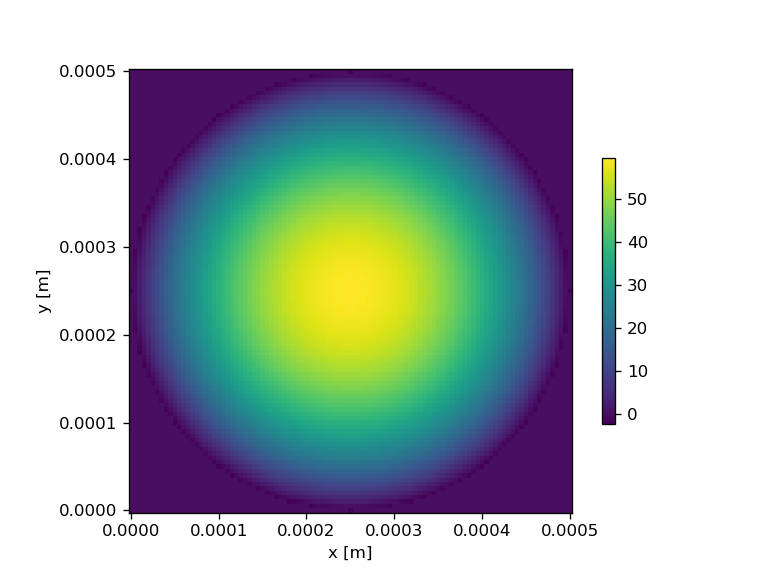

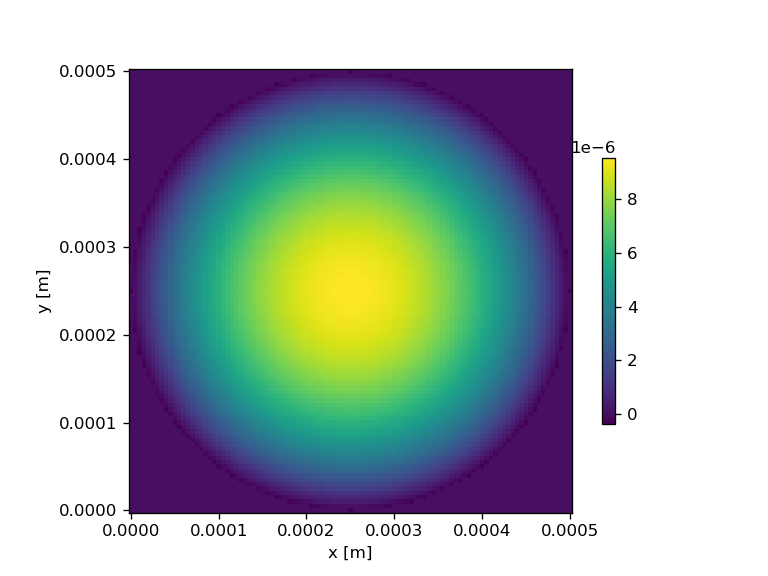

Maximum height of the mask: 1.0045785293160772 um


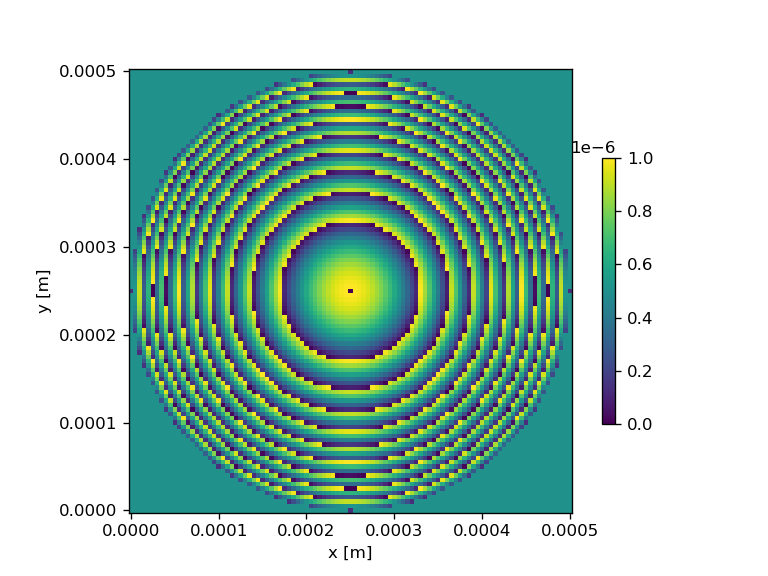

Discretizing mask to number of gray levels:  10


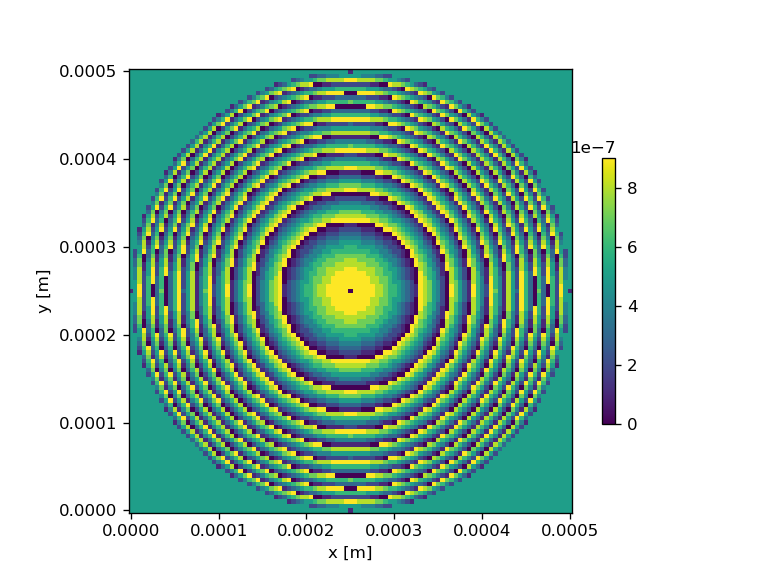

In [28]:

# Unwraps the phase and plots the aperture
mask.phase_unwrap()
moe.plotting.plot_aperture(mask)

# Converts the phase to height 
mask.phase2height(wavelength, refractive_index_633)

moe.plotting.plot_aperture(mask)

# define the maximum height of the mask

height_2pi = moe.sag.phase2height(2*np.pi, wavelength, refractive_index_633)

print(f"Maximum height of the mask: {height_2pi/micro} um")

mask.modulos(height_2pi, normalize_to_max=True)
moe.plotting.plot_aperture(mask)

print("Discretizing mask to number of gray levels: ", n)
mask.discretize(n)
moe.plotting.plot_aperture(mask)

## Export mask to gds and dxf files


`.dxf` files are recorded with layer names with the naming convention   `LevelXXX_0.000` where `XXX` is the layer number and `0.000` is the respetive expected depth for that layer in microns.

In [29]:
gdsname = 'examplemask.gds' # name of dxf file+
dxfname = 'examplemask.dxf' # name of dxf file+


#initialize the GDS converter class 
gdsmask = moe.GDSMask(mask)

# Create layout and merge polygons together if merge=True 
gdsmask.create_layout(mode="raster", merge=True)

gdsmask.write_gds(gdsname)
gdsmask.write_gds(dxfname)

<class 'pyMOE.aperture.Aperture'>
Mask has 10201 number of points distributed in 10 layers
Creating individual pixel polygons
Progress: [####################] 100.0%
[Create Polygons]
Elapsed: 0:00:00.314678
Merging polygons inside layers
Progress: [####################] 100.0%
[Merging polygons]
Elapsed: 0:00:00.047792
[Total time converting to GDS]
Elapsed: 0:00:00.362470
Saving file to examplemask.gds
[Saving GDS file]
Elapsed: 0:00:00.011946
Saved examplemask.gds
Saving file to examplemask.dxf
[Saving GDS file]
Elapsed: 0:00:00.199127
Saved examplemask.dxf


## Convert height map dxf file to grayvalue from calibration lookup table



Grayscale calibration range is 1.789 um
Loaded mask with 10 levels
Mask range is 0.901 um
[Saving calibrated GDS file]
Elapsed: 0:00:00.180209
Saved examplemask_grayscale.dxf


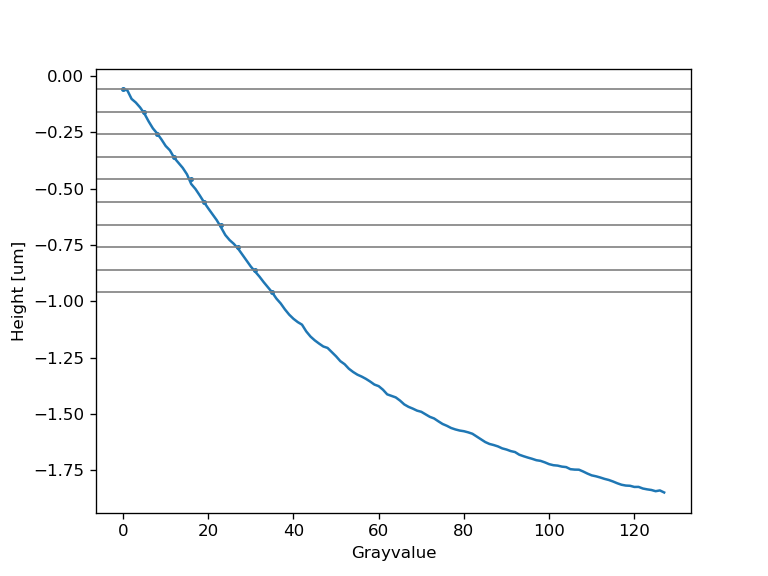

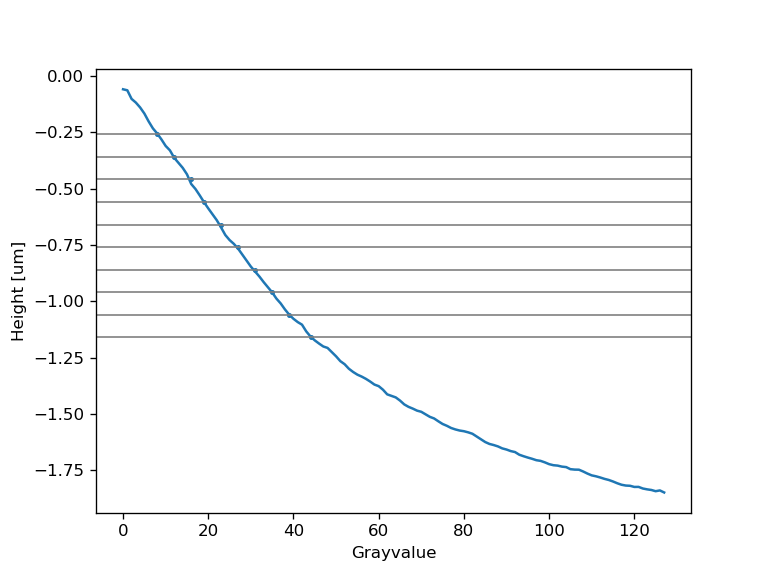

In [30]:
gscalibration = moe.GrayscaleCalibration()

# load calibration file
gscalibration.load_calibration("calibration.csv")


# Load mask file
gscalibration.load_gdsfile(dxfname)

# Extracts the height levels from the layer names
gscalibration.get_levels_from_layer_names()
gscalibration.plot_calibration()



# Adjust the height offset gray values
height_offset = -0.2
gscalibration.adjust_grayvalues(height_offset)
gscalibration.plot_calibration()

outfile = dxfname.replace(".dxf", "_grayscale.dxf")

gscalibration.calibrate_layer_names()


# Add fiducials and alignment marks to the mask

corner_length = 500#*micro
corner_width = 100#*micro

field_width = 10000 #*micro
field_height = 10000 #*micro

# Layer number of the fiducials and label names
layer = "layer127"
gscalibration.add_corners(field_width, field_height, corner_length, corner_width, layer)

# Text to use as label
label = "label 01"
gscalibration.add_label(label, position=(-4000, -4000), mag=1000, layer=layer)

gscalibration.save_calibrated_gdsfile(outfile)




## Transform layered .gds file into a grayscale image

In [31]:
##Start with an existing file 
#Might take a while 
infile = gdsname
outfile = gdsname.replace(".gds", ".bmp")

n=10

moe.importing.gds2img(infile, outfile, int(n),  rescaled=N_pixels/mask_width, verbose=True)


KeyboardInterrupt: 

<Figure size 768x576 with 0 Axes>

## Transform grayscale image into (binary) dithered image 

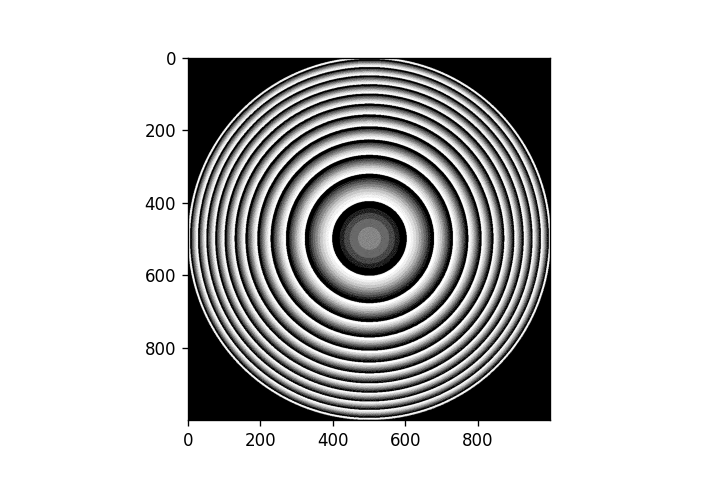

In [ ]:
##Make a dithered mask from the tiff obtained from the gds 
import pyMOE.dither as dith

inputimg = outfile
ditherimg = inputimg.replace(".bmp", "_dither.tiff")


#make dithering using the floyd steinberg algorithm now
moe.dither.dither_img(inputimg, ditherimg, plotting=True)

## Transform binary image file into single layered .gds file

Transform a dithered image into a gds file, using a fractioning of the image


In [7]:
infilxe = ditherimg
outfilxe = infilxe.replace(".tiff", ".gds")


pixelx = 1 #um 
pixely = 1 #um 
cellname = "TOP" #name of the gds cell 
graycolor = 0 #black pixels 
frac = 250 #size of frac pixels in the image 

moe.export.grayim2gds_writer_frac(infilxe, outfilxe, pixelx, pixely, cellname, graycolor, frac, verbose=False)

Sucessfully imported img!
1000
1000
Exported the image file fresnel_phase_mask_ditherx.tiff into fresnel_phase_mask_frac.gds


Transform a dithered image into a .gds file, using the whole image 

In [8]:
infilxe = ditherimg
outfilxe = infilxe.replace(".tiff", "_2.gds")
cellname = "TOP" #name of the gds cell 
graycolor = 0 #black pixels 
pixelx = 1 #um 
pixely = 1 #um 

moe.export.grayim2gds_writer(infilxe, outfilxe, pixelx, pixely,cellname, graycolor, verbose=False)

Sucessfully imported img!
1000
1000
Exported the image file fresnel_phase_mask_ditherx.tiff into fresnel_phase_mask_dithered.gds


In [9]:
###Using instances to create the dithered gds file (faster and less heavy files)

#(Takes less than 1 min)
infilxe = ditherimg
outfilxe = infilxe.replace(".tiff", "_instances.gds")

cellname = "tops" #name of the gds cell 
graycolor = 0 #black pixels 
pixelx = 1 #um 
pixely = 1 #um 

moe.export.grayim2gds_writer_klops(infilxe, outfilxe, pixelx, pixely,cellname, graycolor, verbose=False)

Sucessfully imported img!
1000
1000
Exported the image file fresnel_phase_mask_ditherx.tiff into image.gds
Starting making instances
Done


## Extra: Merging shapes in the single layer .gds file 

The "pixelated" gds files (without instances) are typically large. The file size can be reduced by merging the pixels - the merge operation can be done using the gds_klops module

In [10]:
import pyMOE.gds_klops as gdsops 

inputfile = ditherimg
outputfile = inputfile.replace(".gds", "_merged.gds")
cellname = "TOP" #name of the gds cell 
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile,cellname, layer, datatype ,outputfile )

Merged layers in fresnel_phase_mask_dithered+merged.gds


In [11]:
#uses the instatiated gds 
inputfile = "fresnel_phase_mask_dithered_instances.gds"
outputfile = "fresnel_phase_mask_dithered_instances+merged.gds"
cellname = "TOP" #name of the gds cell 
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile,cellname, layer, datatype ,outputfile )

Merged layers in fresnel_phase_mask_dithered_instances+merged.gds
